# 02_titanic_feature_engineering
Autor: Carlos Wong <br/>
Fecha: 2022_06_11 <br/>
Tipo de problema: CLASIFICACIÓN <br/>
Entradas: 'train' kaggle competition (titanic) <br/>
Salidas: Submission ('PassengerId','Survived')  <br/>
Propósito: Práctica de análisis, visualización, entrenamiento, predicción y documentación
1. `Librerías + Descarga de datos <-------- `
2. Exploración de la variable objetivo
3. EDA (Exploración de datos)
4. `Feature Engineering (Transformación de variables) <-------- `
5. Selección de variables
6. Modelos (pipeline, semilla en train_test split y modelos, comparación modelos)
7. Métricas de evaluación
8. Selección de algoritmo
9. Parametrización de algoritmo
10. Guardado del modelo

## 1. LIBRERÍAS Y EXTRACCIÓN DE DATOS 

In [217]:
# librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [218]:
import warnings
warnings.filterwarnings("ignore")

In [219]:
# librerías sklearn
import sklearn
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

In [220]:
# librerías de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [221]:
# feature engineering de train
# train = pd.read_csv(r'./dataset/train.csv', sep=';')
# X = train.drop(['PassengerId','Survived'], axis=1)  # En 

In [222]:
# feature engineering de test
# test = pd.read_csv(r'./dataset/test.csv')
# X = test.drop(['PassengerId'], axis=1)

In [223]:
X.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [224]:
y.head(2)

0    0
1    1
Name: Survived, dtype: int64

In [225]:
traincolumns = X.columns.tolist()
print(traincolumns)

['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


## 3. Feature Engineering

se <b>eliminan</b> las siguientes variables:

- `PassengerId` - aparentemente no aporta información predictora;
- `Survived` - variable objetivo;
- `Name` - previamente se extrae el 'Title' de cada nombre (Mr, Miss, Mr, etc.);
- `Ticket` - aparentemente no aporta información predictora;
- `Cabin` - previamente se crea columna 'hasCabin' donde, NaN = no tiene cabina (0), código X = sí tiene cabina (1).

se <b>transforman</b> las siguientes variables numéricas:

- `SibSp`, `Parch` - 0 = viaja solo, 1 = no viaja solo

Se <b>infieren</b> de la siguiente manera:

- `Age` - en pipeline sklearn usando kNN;
- `Embarked` - usando la moda.

Se hará <b>scaling</b> en pipeline de sklearn de las siguientes variables numéricas:
- `Fare`;
- `Age`.

Se hará <b>one-hot-encode</b> en pipeline sklearn de las siguientes variables categóricas:

- `Sex`;
- `Embarked`;
- `Title`.

<b>No se modificará</b> - al estar en formato numérico y ser ordinal:

- `Pclass`.

In [226]:
# 'Name' -> 'Title' -> drop 'Name'
X['Title'] = X.Name.str.extract(' ([A-Za-z]+)\.', expand=False)   # Extrae el valor 'Title' de 'Name'
X.drop(['Name'], 1, inplace=True)
X.head(2)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,3,female,47.0,1,0,363272,7.0000,NaN,S,Mrs


In [227]:
# 'Title' -> 'Mr','Mrs','Miss','Master','Other'
X['Title'] = np.where((X['Title'] != 'Mr') & 
                      (X['Title'] != 'Mrs') & 
                      (X['Title'] != 'Miss') & 
                      (X['Title'] != 'Master'), 
                      'Other', X['Title'])   # Convierte todo lo que NO es Mr, Mrs, Miss y Master en 'Other'

In [228]:
# 'Ticket' -> drop 'Ticket'
X.drop(['Ticket'], 1, inplace=True)
X.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,3,male,34.5,0,0,7.8292,NaN,Q,Mr
1,3,female,47.0,1,0,7.0000,NaN,S,Mrs


In [229]:
# 'Cabin' -> 'hasCabin' -> drop 'Cabin'
X['Cabin'] = X['Cabin'].fillna(0)   # convierte todos los NaN en 0
X['hasCabin']= X['Cabin'].apply(lambda x: 0 if x==0 else 1)  # a partir de 'Cabin' convierte todo lo que no es 0 en 1
X.drop(['Cabin'], 1, inplace=True)
X.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,hasCabin
0,3,male,34.5,0,0,7.8292,Q,Mr,0
1,3,female,47.0,1,0,7.0000,S,Mrs,0


In [230]:
# 'SibSp' -> x <= 1 == 1
X['SibSp'] = X.SibSp.apply(lambda x: 1 if x>=1 else x)  # todos los valores mayores o iguales a 1 se vuelven 1

In [231]:
# 'Parch' -> x <= 1 == 1
X['Parch'] = X.Parch.apply(lambda x: 1 if x>=1 else x)  # todos los valores mayores o iguales a 1 se vuelven 1

In [232]:
# 'Embarked' -> moda de 'Embarked'
X['Embarked'].fillna(X['Embarked'].mode()[0], inplace = True)   # se infieren usando la moda

In [233]:
X.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,hasCabin
0,3,male,34.5,0,0,7.8292,Q,Mr,0
1,3,female,47.0,1,0,7.0000,S,Mrs,0


In [234]:
cat_cols = ['Pclass','Sex','SibSp','Parch','Embarked','Title','hasCabin']
num_cols = ['Age','Fare']

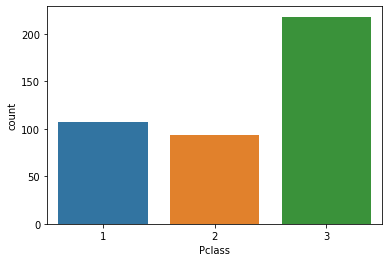

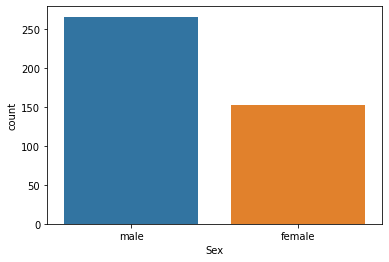

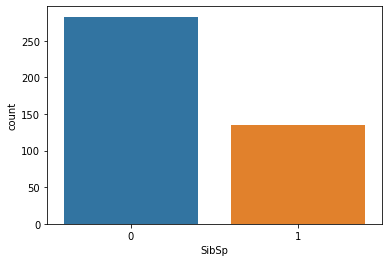

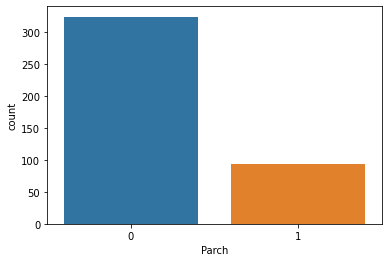

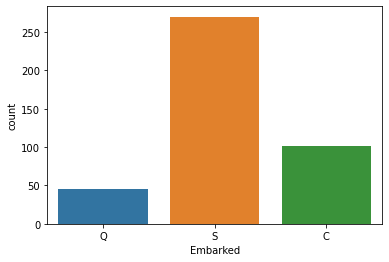

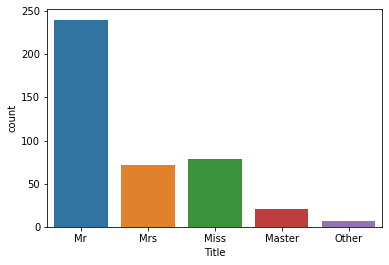

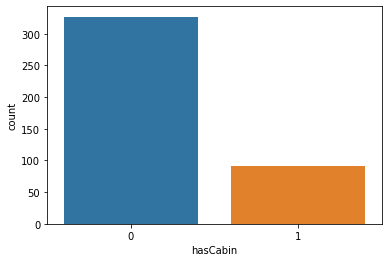

In [235]:
for col in cat_cols:
    sns.countplot(X[col])
    plt.show()

In [236]:
# 'Age' será imputados en el Pipeline de Sklearn
X.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
Title        0
hasCabin     0
dtype: int64

In [237]:
# Para guardar el train después del feature engineering
#train = pd.concat([train['Survived'], X], axis=1)
#train.to_csv('./output/FeatEngin_train_20220611_1.csv', index = False)

In [238]:
# Para guardar el test después del feature engineering
#test = pd.concat([test['PassengerId'], X], axis=1)
#test.to_csv('./output/FeatEngin_test_20220611_1.csv', index = False)